In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
client = makeEfdClient()

# Find Slews

In [3]:
# Select data from a given date
dayObs = 20230629
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
balance_slews = [e for e in events if e.type==TMAState.SLEWING]


In [4]:
# Select data from a given date
dayObs = 20230626
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
raw_slews = [e for e in events if e.type==TMAState.SLEWING]


# Get elevation data

In [5]:
df_mtmount_el_downward_balanced_1=getEfdData(client,'lsst.sal.MTMount.elevation',  event=balance_slews[3], prePadding=-1.7,postPadding=-1.5)
df_mtmount_el_upward_balanced_1=getEfdData(client,'lsst.sal.MTMount.elevation',  event=balance_slews[4], prePadding=-1.7, postPadding=-1.5)

df_mtmount_el_downward_balanced_10=getEfdData(client,'lsst.sal.MTMount.elevation',  event=balance_slews[8], prePadding=-1.7,postPadding=-1.5)
df_mtmount_el_upward_balanced_10=getEfdData(client,'lsst.sal.MTMount.elevation',  event=balance_slews[9], prePadding=-1.7, postPadding=-1.5)



df_mtmount_el_downward_unbalanced=getEfdData(client,'lsst.sal.MTMount.elevation',  event=raw_slews[21], prePadding=-1.7,postPadding=-1.5)
df_mtmount_el_upward_unbalanced=getEfdData(client,'lsst.sal.MTMount.elevation',  event=raw_slews[22], prePadding=-1.7, postPadding=-1.5)

# Pre balancing

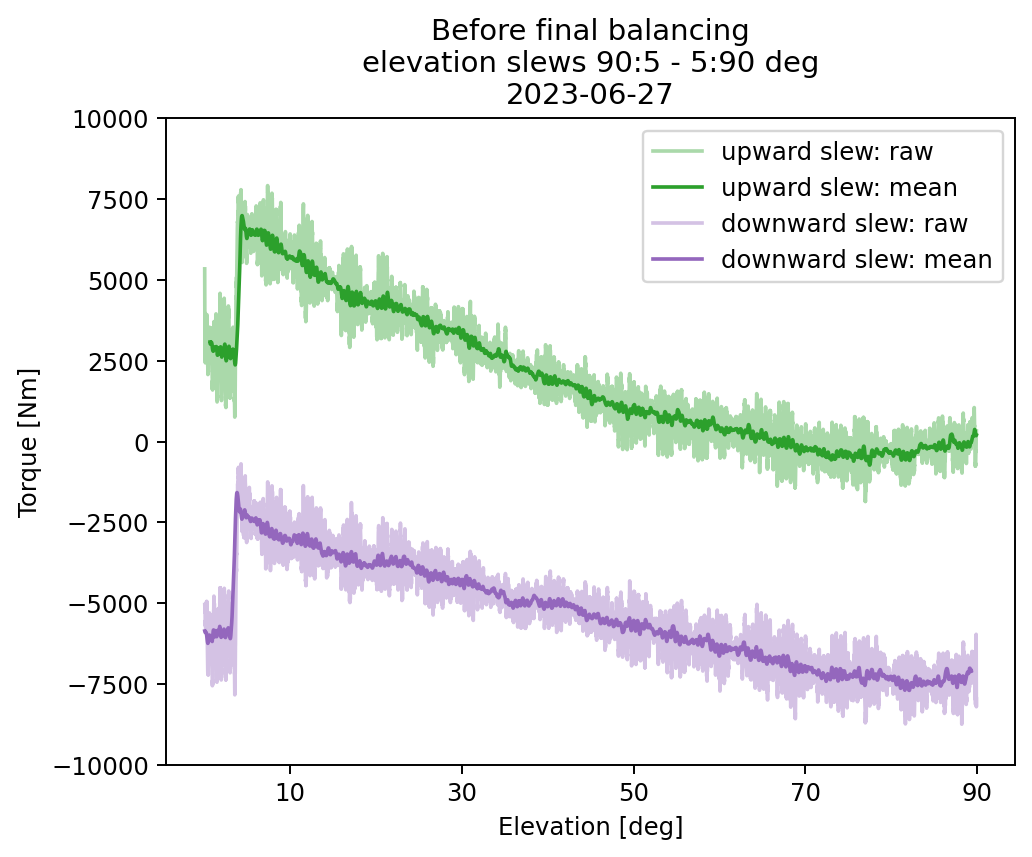

In [10]:
fig=plt.figure(dpi=175, figsize=(6,5))
plt.plot(df_mtmount_el_upward_unbalanced["actualPosition"], 
         df_mtmount_el_upward_unbalanced["actualTorque"], 
         label="upward slew: raw", alpha=0.4, c="tab:green")

plt.plot(df_mtmount_el_upward_unbalanced["actualPosition"], 
         df_mtmount_el_upward_unbalanced["actualTorque"].rolling(100).mean(), 
         label="upward slew: mean", c="tab:green")


plt.plot(df_mtmount_el_downward_unbalanced["actualPosition"], 
         df_mtmount_el_downward_unbalanced["actualTorque"], 
         label="downward slew: raw", alpha=0.4, c="tab:purple")

plt.plot(df_mtmount_el_downward_unbalanced["actualPosition"], 
         df_mtmount_el_downward_unbalanced["actualTorque"].rolling(100).mean(),
         label="downward slew: mean", c="tab:purple")


plt.legend()
plt.title(f"Before final balancing\nelevation slews 90:5 - 5:90 deg\n{raw_slews[22].begin.iso[:-13]}")
plt.ylim(-10000,10000)
plt.xlabel("Elevation [deg]")
plt.ylabel("Torque [Nm]")
_=plt.xticks(np.arange(10,100,20))
fig.tight_layout()
plt.savefig("../plots/elevation_slews_before_balancing_20230627.png")

# After balancing

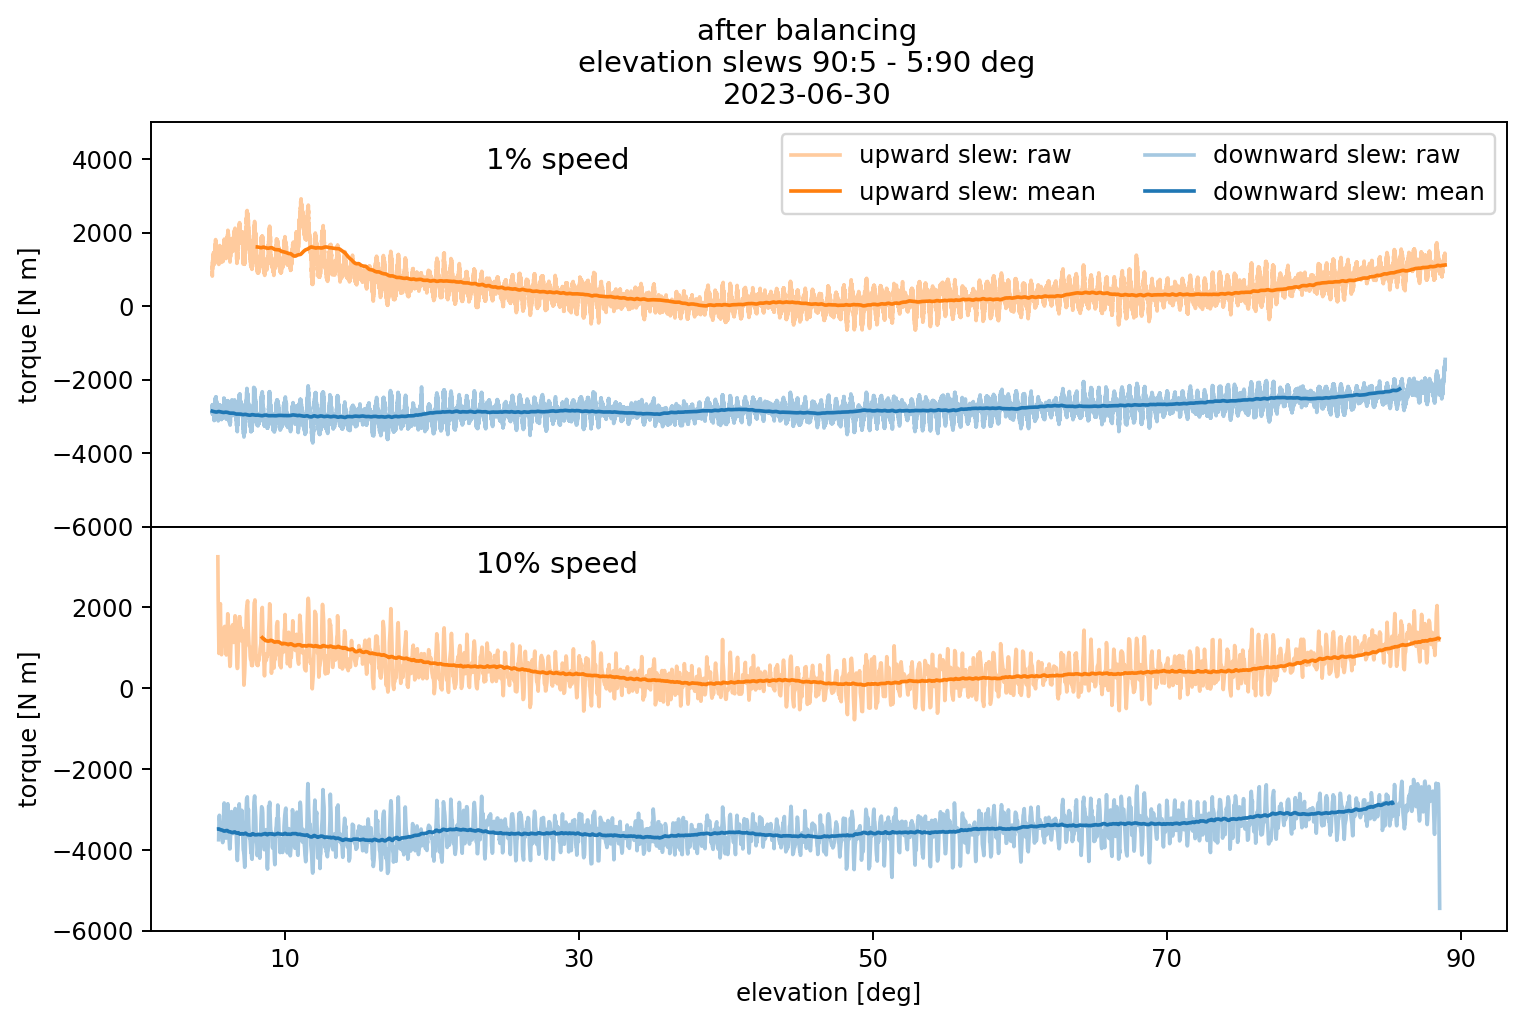

In [7]:
fig,axs=plt.subplots(2,1, dpi=175, figsize=(10,6), sharex=True)
ax=axs[0]
ax.plot(df_mtmount_el_upward_balanced_1["actualPosition"], 
         df_mtmount_el_upward_balanced_1["actualTorque"], 
         label="upward slew: raw", alpha=0.4, c="tab:orange")

ax.plot(df_mtmount_el_upward_balanced_1["actualPosition"], 
         df_mtmount_el_upward_balanced_1["actualTorque"].rolling(1000).mean(), 
         label="upward slew: mean", c="tab:orange")

ax.plot(df_mtmount_el_downward_balanced_1["actualPosition"], 
         df_mtmount_el_downward_balanced_1["actualTorque"], 
         label="downward slew: raw", alpha=0.4, c="tab:blue")
ax.plot(df_mtmount_el_downward_balanced_1["actualPosition"], 
         df_mtmount_el_downward_balanced_1["actualTorque"].rolling(1000).mean(),
         label="downward slew: mean", c="tab:blue")


ax.legend(ncol=2)
ax.set_title("1% speed", y=0.85, x=0.3)
plt.suptitle(f"after balancing\nelevation slews 90:5 - 5:90 deg\n{balance_slews[3].begin.iso[:-13]}")
ax.set_ylim(-6000,5000)
#ax.set_xlabel("elevation [deg]")
ax.set_ylabel("torque [N m]")
#_=ax.set_xticks(np.arange(10,100,20))

ax=axs[1]
ax.plot(df_mtmount_el_upward_balanced_10["actualPosition"], 
         df_mtmount_el_upward_balanced_10["actualTorque"], 
         label="upward slew: raw", alpha=0.4, c="tab:orange")

ax.plot(df_mtmount_el_upward_balanced_10["actualPosition"], 
         df_mtmount_el_upward_balanced_10["actualTorque"].rolling(100).mean(), 
         label="upward slew: mean", c="tab:orange")

ax.plot(df_mtmount_el_downward_balanced_10["actualPosition"], 
         df_mtmount_el_downward_balanced_10["actualTorque"], 
         label="downward slew: raw", alpha=0.4, c="tab:blue")
ax.plot(df_mtmount_el_downward_balanced_10["actualPosition"], 
         df_mtmount_el_downward_balanced_10["actualTorque"].rolling(100).mean(),
         label="downward slew: mean", c="tab:blue")


ax.set_title("10% speed", y=0.85, x=0.3)
ax.set_ylim(-6000,4000)
ax.set_xlabel("elevation [deg]")
ax.set_ylabel("torque [N m]")
_=ax.set_xticks(np.arange(10,100,20))
ax.set_yticks(np.arange(-6e3,4e3,2e3))
plt.subplots_adjust(hspace=0)
#fig.tight_layout()
plt.savefig("../plots/elevation_slews_after_balancing_20230630.png")

# Both on same plot

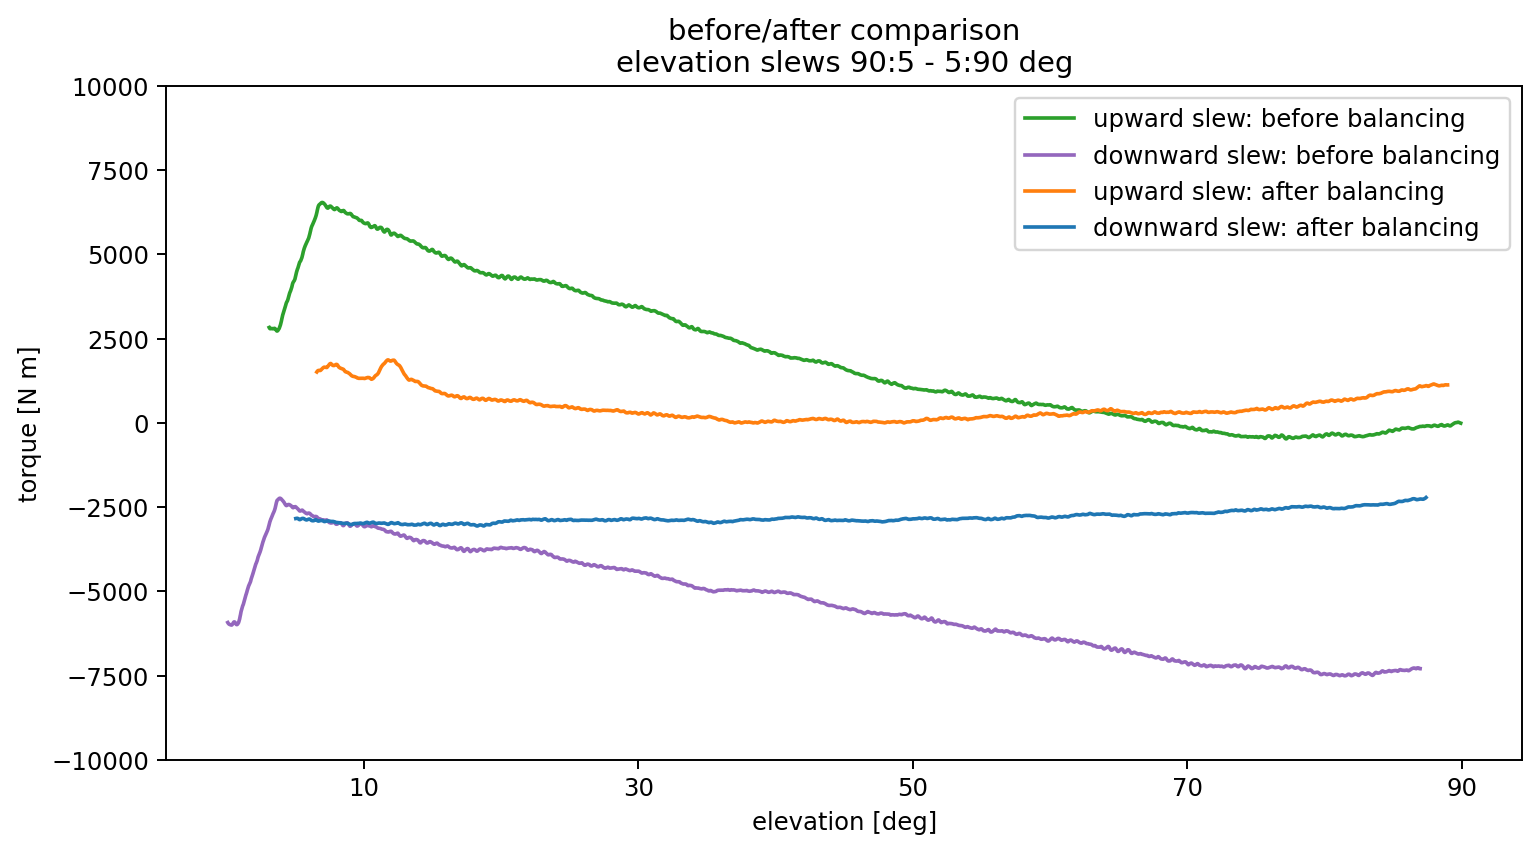

In [76]:

fig=plt.figure(dpi=175, figsize=(10,5))

plt.plot(df_mtmount_el_upward_unbalanced["actualPosition"], 
         df_mtmount_el_upward_unbalanced["actualTorque"].rolling(500).mean(), 
         label="upward slew: before balancing", c="tab:green")
plt.plot(df_mtmount_el_downward_unbalanced["actualPosition"], 
         df_mtmount_el_downward_unbalanced["actualTorque"].rolling(500).mean(),
         label="downward slew: before balancing", c="tab:purple")
plt.plot(df_mtmount_el_upward_balanced_1["actualPosition"], 
         df_mtmount_el_upward_balanced_1["actualTorque"].rolling(500).mean(), 
         label="upward slew: after balancing", c="tab:orange")
plt.plot(df_mtmount_el_downward_balanced_1["actualPosition"], 
         df_mtmount_el_downward_balanced_1["actualTorque"].rolling(500).mean(),
         label="downward slew: after balancing", c="tab:blue")

plt.legend()
plt.title(f"before/after comparison\nelevation slews 90:5 - 5:90 deg")
plt.ylim(-10000,10000)
plt.xlabel("elevation [deg]")
plt.ylabel("torque [N m]")
_=plt.xticks(np.arange(10,100,20))
plt.savefig("../plots/elevation_slews_comparison_20230630.png")

# get azimuth data

In [17]:
balance_slews[37]

dayObs: 20230629
seqNum: 37
type: SLEWING
endReason: STOPPED
duration: 91.55196762084961
begin: <Time object: scale='tai' format='unix_tai' value=1688098015.815911>,
end: <Time object: scale='tai' format='unix_tai' value=1688098107.3678787>
beginFloat: 1688098015.815911
endFloat: 1688098107.3678787


In [12]:
df_mtmount_az=getEfdData(client,'lsst.sal.MTMount.azimuth', 
                                     begin=Time('2023-06-30 02:29:00', format="iso"),
                                     end=Time('2023-06-30 04:30:00', format="iso"))

In [19]:
positive_slews_90=[37,27]
negative_slews_90=[38,28]

positive_slews_0=[31,22]
negative_slews_0=[32,23]

In [47]:
df_mtmount_az_90_positive_1=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[27], prePadding=-1.7,postPadding=-1.5)
df_mtmount_az_90_positive_2=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[37], prePadding=-1.7,postPadding=-1.5)

df_mtmount_az_90_negative_1=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[28], prePadding=-1.7,postPadding=-1.5)
df_mtmount_az_90_negative_2=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[38], prePadding=-1.7,postPadding=-1.5)

df_mtmount_az_0_positive_1=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[21], prePadding=-1.7,postPadding=-1.5)
df_mtmount_az_0_negative_1=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[22], prePadding=-1.7,postPadding=-1.5)

df_mtmount_az_0_positive_2=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[31], prePadding=-1.7,postPadding=-1.5)
df_mtmount_az_0_negative_2=getEfdData(client,'lsst.sal.MTMount.azimuth',  event=balance_slews[32], prePadding=-1.7,postPadding=-1.5)


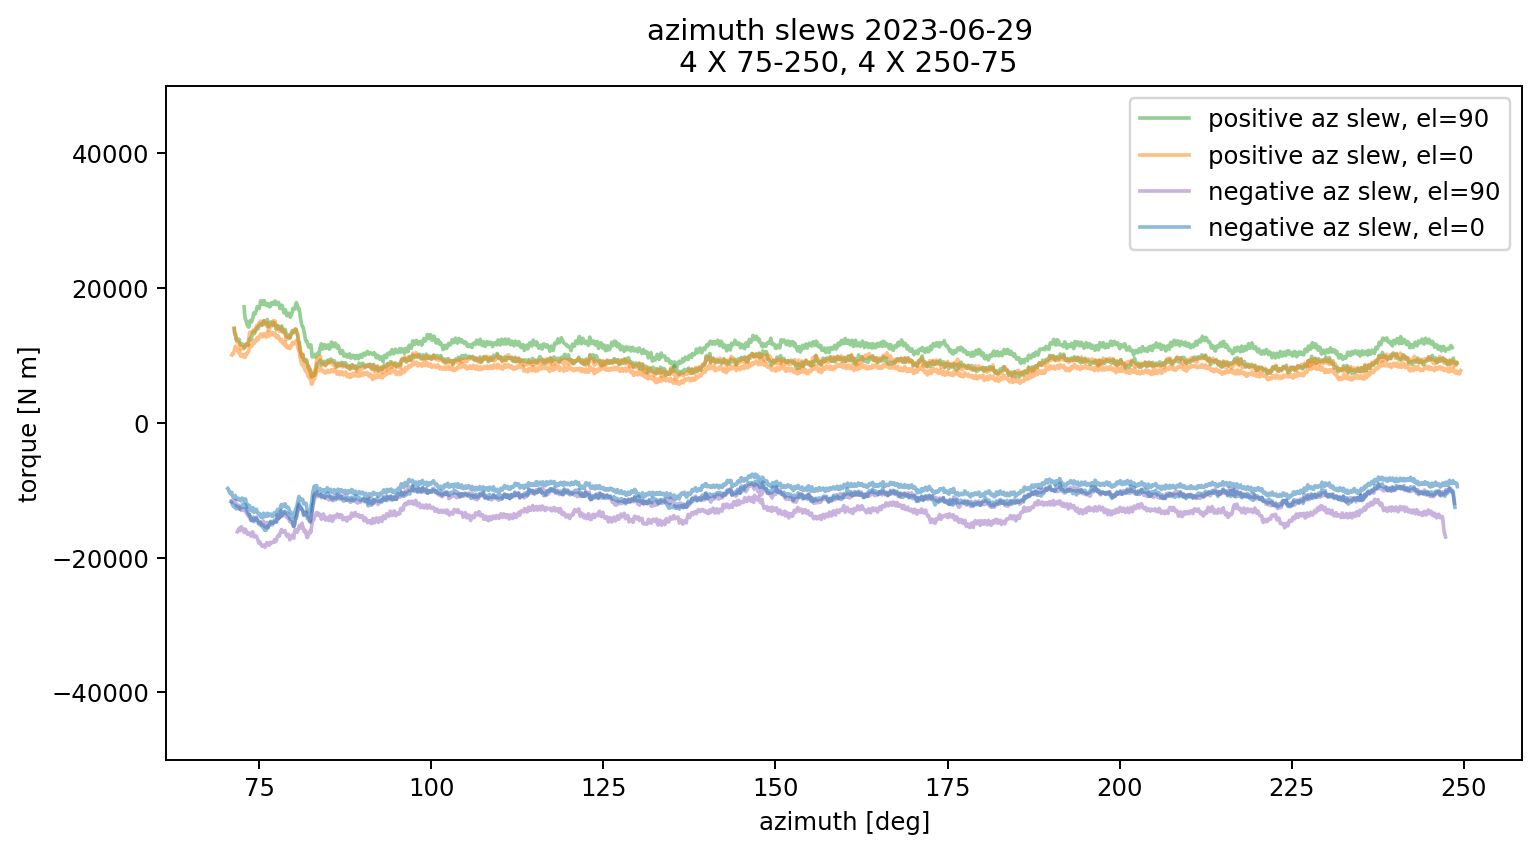

In [60]:
fig=plt.figure(dpi=175, figsize=(10,5))
plt.plot(df_mtmount_az_90_positive_1["actualPosition"], 
         df_mtmount_az_90_positive_1["actualTorque"].rolling(10).mean(), 
         label="positive az slew, el=90", c="tab:green", alpha=0.5)
plt.plot(df_mtmount_az_90_positive_2["actualPosition"], 
         df_mtmount_az_90_positive_2["actualTorque"].rolling(10).mean(), 
         c="tab:green", alpha=0.5)

plt.plot(df_mtmount_az_0_positive_1["actualPosition"], 
         df_mtmount_az_0_positive_1["actualTorque"].rolling(20).mean(),
         label="positive az slew, el=0", c="tab:orange", alpha=0.5)

plt.plot(df_mtmount_az_0_positive_2["actualPosition"], 
         df_mtmount_az_0_positive_2["actualTorque"].rolling(10).mean(),
         c="tab:orange", alpha=0.5)


plt.plot(df_mtmount_az_90_negative_1["actualPosition"], 
         df_mtmount_az_90_negative_1["actualTorque"].rolling(10).mean(),
         label="negative az slew, el=90", c="tab:purple", alpha=0.5)

plt.plot(df_mtmount_az_90_negative_2["actualPosition"], 
         df_mtmount_az_90_negative_2["actualTorque"].rolling(10).mean(),
         c="tab:purple", alpha=0.5)


plt.plot(df_mtmount_az_0_negative_1["actualPosition"], 
         df_mtmount_az_0_negative_1["actualTorque"].rolling(20).mean(),
         label="negative az slew, el=0", c="tab:blue", alpha=0.5)

plt.plot(df_mtmount_az_0_negative_2["actualPosition"], 
         df_mtmount_az_0_negative_2["actualTorque"].rolling(10).mean(),
         c="tab:blue", alpha=0.5)


plt.legend()
plt.title(f"azimuth slews 2023-06-29 \n 4 X 75-250, 4 X 250-75")
plt.ylim(-50000,50000)
plt.xlabel("azimuth [deg]")
plt.ylabel("torque [N m]")
plt.savefig("../plots/azimuth_slews_20230629.png")